Importing Necessary Libraries

In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set_theme()
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.fftpack import fft2
from lazypredict.Supervised import LazyRegressor

Importing the Dataset

In [107]:
# Load the dataset
image_folder = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_1\Set1\Corner"
csv_file = r"C:\Users\91897\Desktop\CP302\Corner Results\Mean_speckle_contrast_values_Corner.csv"

# Loading Y(Mean Speckle Contrast) values from CSV
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:92,4].values.astype(float)  # Taking Mean  column from row 3 to 92 (90 values)
Y = [f"{value:.4f}" for value in Y_values] #Rounding off numbers to 4 decimal points.
print('Mean Speckle Contrast values: ', Y)
print('Number of Mean Speckle contrast values [Y]: ',len(Y))

Mean Speckle Contrast values:  ['0.3883', '0.4200', '0.4467', '0.3962', '0.4008', '0.3468', '0.3980', '0.3844', '0.4402', '0.4465', '0.4224', '0.4230', '0.4498', '0.4118', '0.4059', '0.4278', '0.3949', '0.3973', '0.4677', '0.4441', '0.4474', '0.3886', '0.4578', '0.4326', '0.4048', '0.4782', '0.4326', '0.4254', '0.4409', '0.4652', '0.4555', '0.4676', '0.4787', '0.4474', '0.4189', '0.4678', '0.4338', '0.4298', '0.4578', '0.4644', '0.4687', '0.4038', '0.4412', '0.3919', '0.4253', '0.4081', '0.4272', '0.4491', '0.4409', '0.4335', '0.4523', '0.4359', '0.4414', '0.4397', '0.4065', '0.4242', '0.5026', '0.4054', '0.4823', '0.4589', '0.4861', '0.4476', '0.4255', '0.4850', '0.4508', '0.4539', '0.4694', '0.5079', '0.4490', '0.4101', '0.4642', '0.4427', '0.4229', '0.5166', '0.4417', '0.4460', '0.4377', '0.4108', '0.4078', '0.4056', '0.3968', '0.4317', '0.4260', '0.4315', '0.3963', '0.4052', '0.4061', '0.4543', '0.4443', '0.4110', '0.4348']
Number of Mean Speckle contrast values [Y]:  91


Image Preprocessing and FFT

In [108]:
# Function to apply FFT and return magnitude spectrum
def apply_fourier_transform(image):
    f = np.fft.fft2(image)  # Compute the 2D FFT
    fshift = np.fft.fftshift(f)  # Shift zero frequency components to the center
    magnitude_spectrum = np.abs(fshift)  # Get the magnitude
    return magnitude_spectrum

# Prepare input data X
X_values = []  # Arrays storing spatial data for each speckle image sample
resize = (915,689)  # Define the desired size for all images (change as needed)

# Loop through the images in the specified folder
for image_file in sorted(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    
    if img is not None:
        img_resized = cv2.resize(img, resize)
        img_fft = apply_fourier_transform(img_resized)  # Apply FFT
        X_values.append(img_fft.flatten())  # Flatten the FFT result and store it
    
# Convert to NumPy array
X_values = np.array(X_values,dtype=np.float32)
print('Spatial domain frequency data for speckle images: ',X_values)
print('Shape of input data X:', X_values.shape)
print('No of Image samples fed:',len(X_values))

# Ensure that X and Y have compatible shapes
if len(X_values) != len(Y_values):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')              

Spatial domain frequency data for speckle images:  [[ 5774.743    4952.3315   4993.0103  ...  4993.0103   4952.3315
   5774.743  ]
 [ 2507.4282   1740.0939  14777.711   ... 14777.711    1740.0939
   2507.4282 ]
 [ 5970.846    3392.9158   1496.415   ...  1496.415    3392.9158
   5970.846  ]
 ...
 [10029.81     3151.3264   9679.667   ...  9679.667    3151.3264
  10029.81   ]
 [ 1022.34985  1013.90436   861.9102  ...   861.9102   1013.90436
   1022.34985]
 [ 1977.6206   2863.7917   1162.5005  ...  1162.5005   2863.7917
   1977.6206 ]]
Shape of input data X: (91, 630435)
No of Image samples fed: 91
Compatible shapes and X and Y are matched


Motion Information

In [109]:
# Initialize an empty list to store motion information features
motion_info = []

# Calculate motion features for each image frame
for i in range(1, len(X_values)):
    # Compute the difference between successive frames
    diff = X_values[i] - X_values[i - 1]
    
    # Calculate motion features
    mean_change = np.mean(np.abs(diff))  # Mean absolute change
    std_change = np.std(diff)  # Standard deviation of the change
    max_change = np.max(np.abs(diff))  # Maximum absolute change
    energy_change = np.sum(diff**2)  # Energy of the change

    # Append the features to the motion_info list
    motion_info.append([mean_change, std_change, max_change, energy_change])

# Convert the motion information to a NumPy array
motion_info = np.array(motion_info)

# Since the first image does not have a preceding frame to compare, we can append zeros or mean values
# Append a row of zeros for the first frame
motion_info = np.vstack(([0, 0, 0, 0], motion_info))

# Display the shape and content of the motion information
print('Shape of Motion Information:', motion_info.shape)
print('Motion Information Features:', motion_info)


Shape of Motion Information: (91, 4)
Motion Information Features: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.97275000e+03 1.83255352e+04 2.30826700e+06 2.11751249e+14]
 [6.99827295e+03 1.76830312e+04 2.04558700e+06 1.97131801e+14]
 [7.02826367e+03 1.74703691e+04 1.51446550e+06 1.92429433e+14]
 [7.06261523e+03 1.82223496e+04 2.29564300e+06 2.09341722e+14]
 [6.93638232e+03 1.72903613e+04 1.42030175e+06 1.88505259e+14]
 [6.85190039e+03 1.75321367e+04 2.01874800e+06 1.93792615e+14]
 [6.76447168e+03 1.65032402e+04 1.58454150e+06 1.71703330e+14]
 [6.92093945e+03 1.79344824e+04 3.17996400e+06 2.02814010e+14]
 [6.91407227e+03 1.70218047e+04 1.10041350e+06 1.82663533e+14]
 [6.97534717e+03 1.81483828e+04 1.77878225e+06 2.07644086e+14]
 [6.98306836e+03 1.82825684e+04 1.60505950e+06 2.10726430e+14]
 [7.03630713e+03 1.77592188e+04 2.94024000e+06 1.98911545e+14]
 [7.21953809e+03 1.82133379e+04 1.37274338e+06 2.09151251e+14]
 [7.15330615e+03 2.03935020e+04 6.66369200e+06 2.625

Data preprocessing

In [110]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Convert Y from a list of strings to a NumPy array of floats
Y = np.array(Y_values, dtype=np.float32)

# Ensure that X and Y have compatible shapes
if len(motion_info) != len(Y):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(motion_info)


# Splitting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_test:',y_test.shape)



Compatible shapes and X and Y are matched
Shape of X_train: (72, 4)
Shape of y_train: (72,)
Shape of X_test: (19, 4)
Shape of y_test: (19,)


Lazy Regressor

In [111]:
reg = LazyRegressor(verbose=0, 
                    ignore_warnings=False, 
                    custom_metric=None) 
  
# fitting data in Lazyregressor 
models, predictions = reg.fit(X_train, X_test, 
                              y_train, y_test) 

print(models)

100%|██████████| 42/42 [00:00<00:00, 52.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 4
[LightGBM] [Info] Start training from score 0.433517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Results

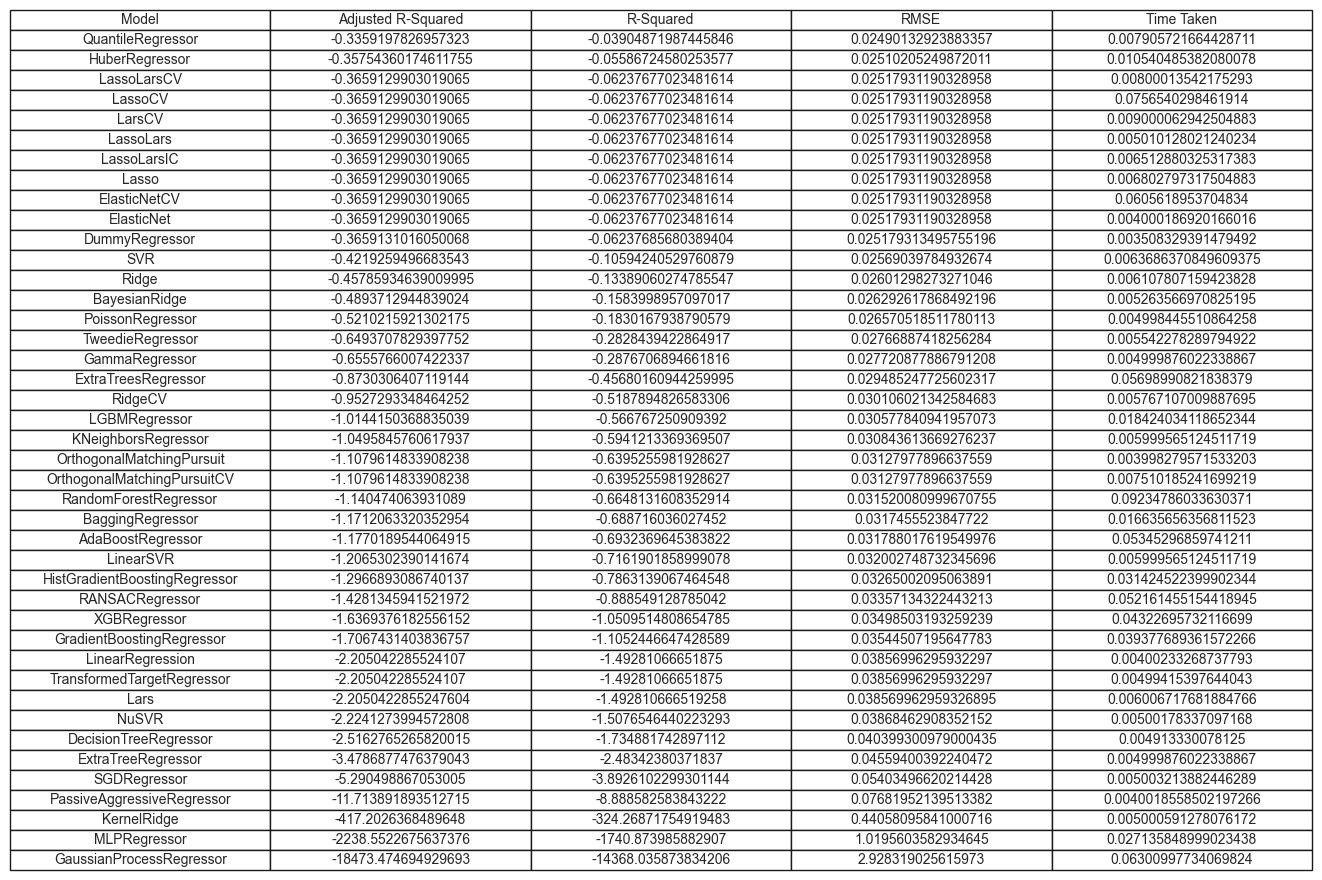

Table saved as an image at: C:\Users\91897\Desktop\CP302\ML Results\LazyRegressor\Corner\C1_set1.png


In [112]:
# Save the model results as an image
output_dir = r"C:\Users\91897\Desktop\CP302\ML Results\LazyRegressor\Corner"
output_file = os.path.join(output_dir, "C1_set1.png")

# Adding the "Model" names as the first column
models_reset = models.reset_index()  # Move the index (model names) into a column

# Plotting the table using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=models_reset.values, colLabels=models_reset.columns, cellLoc='center', loc='center')

# Adjust table properties for better readability
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  

# Save the figure
plt.savefig(output_file, bbox_inches='tight', dpi=300)
plt.show()

print(f"Table saved as an image at: {output_file}")